In [3]:
import pandas as pd
import numpy as np
from finance_byu.summarize import summary
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load daily and monthly crsp data

daily = pd.read_feather("~/Data/crsp_daily.ftr")

monthly = pd.read_feather("~/Data/crsp_monthly.ftr")

daily.head()

,permno,caldt,shrcd,excd,siccd,prc,ret,vol,shr
0,10000,1986-01-07,10,3,3990,-2.5625,NaN,1000.0,3680.0
1,10000,1986-01-08,10,3,3990,-2.5000,-0.02439,12800.0,3680.0
2,10000,1986-01-09,10,3,3990,-2.5000,0.00000,1400.0,3680.0
3,10000,1986-01-10,10,3,3990,-2.5000,0.00000,8500.0,3680.0
4,10000,1986-01-13,10,3,3990,-2.6250,0.05000,5450.0,3680.0


In [5]:
# Clean daily data

daily['prc'] = abs(daily['prc'])

daily.sort_values(by=['permno', 'caldt'], inplace=True)

daily = daily[['permno', 'caldt', 'prc', 'ret']]

daily['mdt'] = daily['caldt'].dt.to_period('M').astype(str)

daily.head()

,permno,caldt,prc,ret,mdt
0,10000,1986-01-07,2.5625,NaN,1986-01
1,10000,1986-01-08,2.5000,-0.02439,1986-01
2,10000,1986-01-09,2.5000,0.00000,1986-01
3,10000,1986-01-10,2.5000,0.00000,1986-01
4,10000,1986-01-13,2.6250,0.05000,1986-01


In [6]:
# Create up, down, and total columns

daily['up'] = np.where(daily['ret'] > 0, 1, 0)

daily['down'] = np.where(daily['ret'] < 0, 1, 0)

daily['total'] = 1

daily.head()

,permno,caldt,prc,ret,mdt,up,down,total
0,10000,1986-01-07,2.5625,NaN,1986-01,0,0,1
1,10000,1986-01-08,2.5000,-0.02439,1986-01,0,1,1
2,10000,1986-01-09,2.5000,0.00000,1986-01,0,0,1
3,10000,1986-01-10,2.5000,0.00000,1986-01,0,0,1
4,10000,1986-01-13,2.6250,0.05000,1986-01,1,0,1


In [7]:
# Aggregate daily data on the month level. Sum up, down, and total days in each month

daily = daily.groupby(['permno','mdt'])[['caldt','prc','up','down', 'total']].agg({'caldt': 'last','prc': 'last','up':'sum','down':'sum', 'total':'sum'})

daily.reset_index("mdt",inplace=True)
daily.reset_index("permno",inplace=True)

daily['%neg-%pos'] = (daily['down']-daily['up']) / daily['total']

daily

,permno,mdt,caldt,prc,up,down,total,%neg-%pos
0,10000,1986-01,1986-01-31,4.37500,8,3,19,-0.263158
1,10000,1986-02,1986-02-28,3.25000,2,9,19,0.368421
2,10000,1986-03,1986-03-31,4.43750,7,2,20,-0.250000
3,10000,1986-04,1986-04-30,4.00000,2,9,22,0.318182
4,10000,1986-05,1986-05-30,3.10938,5,12,21,0.333333
...,...,...,...,...,...,...,...,...
5001716,93436,2023-08,2023-08-31,258.07999,9,14,23,0.217391
5001717,93436,2023-09,2023-09-29,250.22000,8,12,20,0.200000
5001718,93436,2023-10,2023-10-31,200.84000,10,12,22,0.090909
5001719,93436,2023-11,2023-11-30,240.08000,14,7,21,-0.333333


In [8]:
# Clean monthly data

daily = daily[['permno','caldt','%neg-%pos']]

monthly = monthly[['permno','caldt','prc','ret', 'shr']]

monthly.head()

,permno,caldt,prc,ret,shr
0,10000,1986-01-31,-4.37500,NaN,3680.0
1,10000,1986-02-28,-3.25000,-0.257143,3680.0
2,10000,1986-03-31,-4.43750,0.365385,3680.0
3,10000,1986-04-30,-4.00000,-0.098592,3793.0
4,10000,1986-05-30,-3.10938,-0.222656,3793.0


In [9]:
# Merge aggregated daily data with monthly data

df = pd.merge(monthly,daily,on=['permno','caldt'],how='inner')

df.head()

,permno,caldt,prc,ret,shr,%neg-%pos
0,10000,1986-01-31,-4.37500,NaN,3680.0,-0.263158
1,10000,1986-02-28,-3.25000,-0.257143,3680.0,0.368421
2,10000,1986-03-31,-4.43750,0.365385,3680.0,-0.250000
3,10000,1986-04-30,-4.00000,-0.098592,3793.0,0.318182
4,10000,1986-05-30,-3.10938,-0.222656,3793.0,0.333333


In [10]:
# Calculate PRET

# Log Returns
df['logret'] = np.log(1 + df['ret'])

# Momentum from t-12 to t-2
df['pret'] = df.groupby('permno')['logret'].rolling(11,11).sum().reset_index(drop=True)
df['pret'] = df.groupby('permno')['pret'].shift(2)

# 6 month holding period returns
df['ret_6'] = df.groupby('permno')['logret'].rolling(6,6).sum().reset_index(drop=True)
df['ret_6'] = df.groupby('permno')['ret_6'].shift(-6)

df.head()

,permno,caldt,prc,ret,shr,%neg-%pos,logret,pret,ret_6
0,10000,1986-01-31,-4.37500,NaN,3680.0,-0.263158,NaN,NaN,-0.430783
1,10000,1986-02-28,-3.25000,-0.257143,3680.0,0.368421,-0.297252,NaN,-1.089044
2,10000,1986-03-31,-4.43750,0.365385,3680.0,-0.250000,0.311436,NaN,-1.459321
3,10000,1986-04-30,-4.00000,-0.098592,3793.0,0.318182,-0.103797,NaN,-1.633155
4,10000,1986-05-30,-3.10938,-0.222656,3793.0,0.333333,-0.251872,NaN,-1.323014


In [11]:
# Calculate ID

# Rolling average %neg-%pos from t-12 to t-2
df['id'] = df.groupby('permno')['%neg-%pos'].rolling(11,11).mean().reset_index(drop=True)
df['id'] = df.groupby('permno')['id'].shift(2)

# Compute ID as sign(pret) * %neg-%pos
df['id'] = np.sign(df['pret']) * df['id']

df.head()

,permno,caldt,prc,ret,shr,%neg-%pos,logret,pret,ret_6,id
0,10000,1986-01-31,-4.37500,NaN,3680.0,-0.263158,NaN,NaN,-0.430783,NaN
1,10000,1986-02-28,-3.25000,-0.257143,3680.0,0.368421,-0.297252,NaN,-1.089044,NaN
2,10000,1986-03-31,-4.43750,0.365385,3680.0,-0.250000,0.311436,NaN,-1.459321,NaN
3,10000,1986-04-30,-4.00000,-0.098592,3793.0,0.318182,-0.103797,NaN,-1.633155,NaN
4,10000,1986-05-30,-3.10938,-0.222656,3793.0,0.333333,-0.251872,NaN,-1.323014,NaN


In [12]:
# Filter by prc >= 5 and days that features are NaN

df['prclag'] = df.groupby('permno')['prc'].shift(1)

df = df.query("pret == pret and id == id and prclag >= 5").reset_index(drop=True)

df.head()

,permno,caldt,prc,ret,shr,%neg-%pos,logret,pret,ret_6,id,prclag
0,10001,1987-02-27,6.250,-0.074074,991.0,0.210526,-0.076961,0.196692,0.073271,-0.027102,6.750
1,10001,1987-03-31,6.375,0.036800,991.0,-0.090909,0.036139,0.140122,0.014572,-0.000216,6.250
2,10001,1987-04-30,-6.125,-0.039216,991.0,-0.095238,-0.040006,0.038273,0.074380,0.023468,6.375
3,10001,1987-07-31,6.000,0.021277,991.0,-0.136364,0.021054,-0.026546,0.075197,-0.015656,5.875
4,10001,1987-08-31,6.500,0.083333,991.0,-0.142857,0.080042,0.033860,0.072115,0.003259,6.000


In [13]:
# Bin on momentum first and then ID

df['mombins'] = df.groupby("caldt")['pret'].transform(lambda x: pd.qcut(x, 2, labels=False))

df['idbins'] = df.groupby(['caldt','mombins'])['id'].transform(lambda x: pd.qcut(x, 5, labels=False))

df.head()

,permno,caldt,prc,ret,shr,%neg-%pos,logret,pret,ret_6,id,prclag,mombins,idbins
0,10001,1987-02-27,6.250,-0.074074,991.0,0.210526,-0.076961,0.196692,0.073271,-0.027102,6.750,1,2
1,10001,1987-03-31,6.375,0.036800,991.0,-0.090909,0.036139,0.140122,0.014572,-0.000216,6.250,1,3
2,10001,1987-04-30,-6.125,-0.039216,991.0,-0.095238,-0.040006,0.038273,0.074380,0.023468,6.375,0,4
3,10001,1987-07-31,6.000,0.021277,991.0,-0.136364,0.021054,-0.026546,0.075197,-0.015656,5.875,0,3
4,10001,1987-08-31,6.500,0.083333,991.0,-0.142857,0.080042,0.033860,0.072115,0.003259,6.000,0,3


In [24]:
# Form portfolios on momentum and ID bins

port_6 = df.groupby(['caldt', 'mombins', 'idbins'])['ret_6'].mean().unstack(level=['mombins', 'idbins'])*100

# Drop the days that we don't know the 6 month holding period return
port_6 = port_6.dropna() 

port_6.head()

mombins            0                                                    1  \
idbins             0         1          2         3          4          0   
caldt                                                                       
1927-01-31 -0.411569  4.986741  10.889279  7.465498  16.467943  20.331130   
1927-02-28  3.471052 -4.252114   1.568479  3.321471   2.064443  15.558809   
1927-03-31  9.446599  7.097514  10.824263  6.998256   8.408432  17.924903   
1927-04-30  7.386290  7.857119   0.511986  4.716228   0.929097   9.744316   
1927-05-31  8.959035  9.327137   5.910097  7.670196   5.527828  10.760247   

mombins                                                
idbins              1          2          3         4  
caldt                                                  
1927-01-31  15.522765  15.466614  20.126409  0.022675  
1927-02-28  12.055867  13.421222  11.871359  5.579288  
1927-03-31  20.472909  18.773415  13.861936  9.621672  
1927-04-30  13.765565  12.184404  11.776646  1.448877  
1927-05-31  10.910460  15.845587  14.596748  5.048426

In [25]:
# Summarize each portfolios performance using the BYU Finance library

summary(port_6).loc[['count','mean','std','tstat']].round(3)

mombins         0                                                 1            \
idbins          0         1         2         3         4         0         1   
count    1158.000  1158.000  1158.000  1158.000  1158.000  1158.000  1158.000   
mean       -1.288     0.735     1.514     1.741     1.525     3.987     3.894   
std        20.217    18.910    18.066    17.996    18.344    15.929    15.582   
tstat      -2.168     1.322     2.851     3.293     2.829     8.518     8.504   

mombins                                
idbins          2         3         4  
count    1158.000  1158.000  1158.000  
mean        3.647     3.011     1.398  
std        16.296    17.220    18.354  
tstat       7.616     5.950     2.592

In [26]:
# Create winners minus losers portfolios

spread_6 = port_6[1] - port_6[0] # Bin 1 is good momentum and bin 0 is bad momentum

# Create a continuous minus discrete portfolio

spread_6['spread'] = spread_6[0] - spread_6[4] # Negative ID is continuous. Bin 0 is the most continuous and bin 4 is the most discrete

summary(spread_6).loc[['count','mean','std','tstat']].round(3)

idbins,0,1,2,3,4,spread
count,1158.000,1158.000,1158.000,1158.000,1158.000,1158.000
mean,5.275,3.159,2.133,1.269,-0.127,5.402
std,10.158,8.265,7.230,7.266,7.620,10.683
tstat,17.673,13.007,10.042,5.945,-0.567,17.209


In [30]:
# Calculate the cummulative compounded return over the lifetime of the strategy

port = df.groupby(['caldt', 'mombins', 'idbins'])['ret'].mean().unstack(level=['mombins', 'idbins'])*100

port = port.dropna() 

spread = port[1] - port[0] # Bin 1 is good momentum and bin 0 is bad momentum

spread['spread'] = spread[0] - spread[4] # Negative ID is continuous. Bin 0 is the most continuous and bin 4 is the most discrete

spread['cum_ret'] = (1+(spread['spread']/100)).cumprod() - 1

spread.head()

idbins,0,1,2,3,4,spread,cum_ret
caldt,,,,,,,
1927-01-31,3.989406,-1.884506,-3.626712,-1.840176,1.229248,2.760158,0.027602
1927-02-28,-3.703311,0.803391,-1.886880,-2.406565,-0.033129,-3.670183,-0.010113
1927-03-31,6.051508,4.415634,1.465318,-0.871492,3.299995,2.751513,0.017124
1927-04-30,1.107216,1.716147,4.865159,1.502961,0.069382,1.037834,0.027680
1927-05-31,8.251800,0.679173,-0.016085,2.607655,2.825827,5.425973,0.083441


Text(0.5, 1.0, 'Back Test')

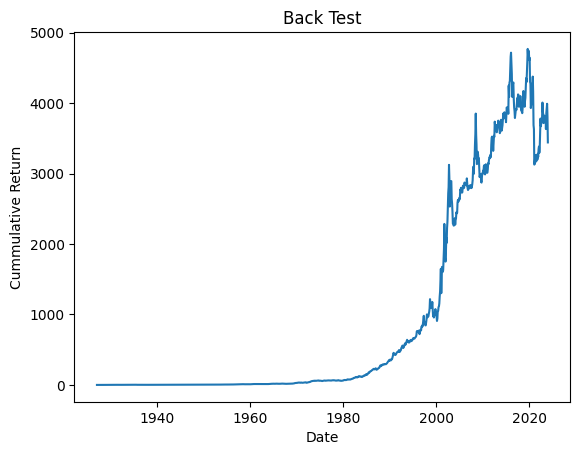

In [31]:
# Plot the cummulative returns

sns.lineplot(data=spread,x='caldt',y='cum_ret')

plt.ylabel("Cummulative Return")

plt.xlabel("Date")

plt.title("Back Test")